In [1]:
import pandas as pd
from os import listdir
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [2]:
# Give access to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
df = pd.read_csv("gdrive/MyDrive/Data_for_ML/NHLPP_Data/All_Data.csv")
df = df.set_index("Name_GP")
df

,Age,Pos,GP,G,A,P,PIM,+/-,TOI,ES,...,A/GP,P/GP,SHOTS,SH%,HITS,BS,FOW,FOL,FO%,Pend
Name_GP,,,,,,,,,,,,,,,,,,,,,
Connor McDavid_43,25,1,43,35,44,79,20,2,1359,1024,...,1.023,1.837,170,20.6,37,24,258,265,49.33,153
Leon Draisaitl_41,27,1,41,23,40,63,20,3,1335,1017,...,0.976,1.537,132,17.4,26,28,416,363,53.40,128
Nikita Kucherov_39,29,1,39,16,43,59,22,1,1249,990,...,1.103,1.513,139,11.5,33,14,0,0,0.00,113
David Pastrnak_40,26,1,40,32,26,58,24,20,1188,945,...,0.650,1.450,203,15.8,41,15,5,7,41.67,113
Jason Robertson_42,23,1,42,29,29,58,8,23,1120,931,...,0.690,1.381,172,16.9,23,7,0,1,0.00,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MacKenzie Entwistle_62,23,1,62,3,6,9,14,-13,709,615,...,0.097,0.145,45,6.7,117,26,75,87,46.30,10
Mattias Samuelsson_52,22,0,52,1,8,9,20,10,1319,1148,...,0.154,0.173,72,1.4,100,86,0,0,0.00,10
Brad Hunt_43,34,0,43,3,5,8,12,1,671,665,...,0.116,0.186,42,7.1,14,9,0,0,0.00,10


# Split Data

In [4]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = df_train.Pend
y_val = df_val.Pend
y_test = df_test.Pend

del df_train['Pend']
del df_val['Pend']
del df_test['Pend']

In [5]:
# Convert target to pytorch-friendly shapes
y_train = torch.from_numpy(y_train.values.reshape(-1,1).astype(np.float32))
y_val = torch.from_numpy(y_val.values.reshape(-1,1).astype(np.float32))
y_test = torch.from_numpy(y_test.values.reshape(-1,1).astype(np.float32))

In [6]:
base = list(df_train.columns)

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values.astype(np.float32)
    return torch.tensor(X)

len(base)

47

In [7]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
X_test = prepare_X(df_test)

In [8]:
# Normalize the data
def normalize(X):
  mean = X.mean(dim=0)
  std = X.std(dim=0)

  # Make sure std is not zero to avoid division by zero
  std[std == 0] = 1.0

  X_normalized = (X - mean) / std
  return X_normalized

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

# Create the Model

In [34]:
nmid = 2500
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(47, nmid)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(nmid, 1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        return self.layer2(x)

In [35]:
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005)

In [36]:
# Move model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

## Train the Model

In [37]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [38]:
n_epochs = 50000

# Hold best model
val_acc = []
epoch_n = []

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model(X_train)

    # Compute the loss
    loss = criterion(y_pred, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Get epoch numbers, loss value, and validation loss
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {np.sqrt(loss.item()):.4f}')
        with torch.no_grad():
          y_pred_val = model(X_val)
          epoch_n.append(epoch)
          acc = rmse(y_val.cpu(), y_pred_val.cpu()).item()
          val_acc.append(acc)
          print("val acc = ", acc)


Epoch [500/50000], Loss: 8.2211
val acc =  9.373669624328613
Epoch [1000/50000], Loss: 7.4777
val acc =  8.809427261352539
Epoch [1500/50000], Loss: 7.0674
val acc =  8.560568809509277
Epoch [2000/50000], Loss: 6.7691
val acc =  8.423315048217773
Epoch [2500/50000], Loss: 6.5221
val acc =  8.331096649169922
Epoch [3000/50000], Loss: 6.3050
val acc =  8.262083053588867
Epoch [3500/50000], Loss: 6.1076
val acc =  8.204473495483398
Epoch [4000/50000], Loss: 5.9235
val acc =  8.152628898620605
Epoch [4500/50000], Loss: 5.7491
val acc =  8.105087280273438
Epoch [5000/50000], Loss: 5.5817
val acc =  8.059775352478027
Epoch [5500/50000], Loss: 5.4210
val acc =  8.017552375793457
Epoch [6000/50000], Loss: 5.2668
val acc =  7.977987289428711
Epoch [6500/50000], Loss: 5.1182
val acc =  7.940449237823486
Epoch [7000/50000], Loss: 4.9741
val acc =  7.905817031860352
Epoch [7500/50000], Loss: 4.8352
val acc =  7.873973369598389
Epoch [8000/50000], Loss: 4.7007
val acc =  7.8459062576293945
Epoch [8

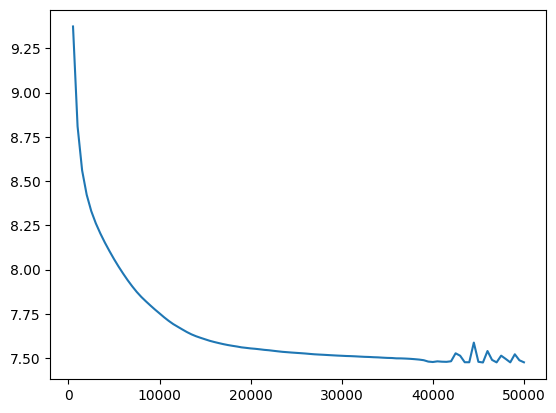

In [39]:
plt.plot(epoch_n, val_acc)
plt.show()

In [570]:
min(val_acc)

6.725841045379639

## Inspect performance on Validation data

In [171]:
with torch.no_grad():
    y_pred_val = model(X_val)
    print('RMSE:', rmse(y_val.cpu(), y_pred_val.cpu()).item())

RMSE: 7.8090338706970215


In [40]:
with torch.no_grad():
    y_pred_test = model(X_test)
    print('RMSE:', rmse(y_test.cpu(), y_pred_test.cpu()).item())

RMSE: 7.317544937133789
